# MATH 578 Lab Assignment 3 <a class="tocSkip">


***Kai Yang***

Original assignment problems are put in *italic fonts*, my text answers are put in **bold fonts**. For both parts, the functions written are in the constructed classes. 

Another interesting thing to note is that, to run the entire thing on GPU, simply use `cupy` instead of `numpy` -- but for the purpose of the assignment, we will stay with `numpy`. The installed `numpy` version at time of completion of this assignment is `1.19.2`.

**All computational functions are consisted in the following class `lab3`.**

In [1]:
import numpy as np
import timeit
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')  # this is just to hide all the warnings


class lab3:
    '''
    The class created for this lab assignment. Basically a class to implement Runge-Kutta to numerically solve first order continuous time IVP. 
    '''
    def __init__(self):
        '''
        Class constructor 
        '''
        pass

    def Euler(self,
              direction,
              h,
              num_iter,
              f,
              u_0,
              t_0,
              tol=1e-6,
              nabla_f="empty"):
        '''
        (for problem 1) Forward/backward Euler's method
        Parameters: 
            direction: string
                Choose "forward" for forward Euler's method, or "backward" for backward Euler's method 
            h: floating point scalar
                Step size for Euler's method 
            num_iter: integer scalar
                Number of iterations to run
            f: function
                Function for du/dt; the function itself should take value of 1-D array u and scalar t, and output 1-D array as values of f
            u_0: floating point 1-D array
                Initial value for u 
            t_0: floating point scalar
                Initial value for t 
            tol: floating point scalar; default 1e-6
                Tolerance parameter to pass to self.newton
            nabla_f: function; default "empty" for it's not used for forward Euler's method 
                Function for derivative of f; the function itself should take value of 1-D array u and scalar t, and output 2-D array as the derivative of f
        Returns:
            u: floating point 2-D array
                Array consisting of u values corresponding to t values above
            t: floating point 1-D array
                Array consisting of t values
            N: interger scalar
                Total number of function evaluations
        '''
        # initialize arrays used for outputs
        u = np.empty((num_iter + 1, len(u_0)))
        u[0] = u_0
        t = np.arange(num_iter + 1, dtype=float)
        t *= h
        t += t_0
        N = 0

        # forward Euler's method
        if direction == "forward":
            for k in np.arange(num_iter):
                u[k + 1, :] = u[k, :] + h * f(u=u[k, :], t=t[k])
                N += 1
        # backward Euler's method
        elif direction == "backward":
            if nabla_f == "empty":
                return "Please input nabla_f; i.e., the function for derivative of f."
            for k in np.arange(num_iter):
                x = u[k, :] + h * f(
                    u=u[k, :],
                    t=t[k])  # use forward Euler to make an initial guess
                # Newton iteration
                converged = False
                while not converged:
                    g = x - u[k, :] - h * f(u=x, t=t[k + 1])
                    N += 1
                    nabla_g = np.eye(len(u_0)) - h * nabla_f(x, t)
                    d = np.linalg.solve(
                        nabla_g, g
                    )  # here I use numpy built-in method to solve linear system -- it probably uses a modified GMRES or CG anyway, not the point for this assignemnt
                    converged = np.allclose(
                        0, d, rtol=0, atol=tol, equal_nan=False
                    )  # the updating formula for Newton's iteration allows us to do this
                    x -= d
                u[k + 1, :] = x
        # in case there is a mistake in input...
        else:
            print(
                "Choose \"forward\" for forward Euler's method, or \"backward\" for backward Euler's method."
            )
        return u, t, N

    def Runge(self, h, num_iter, f, u_0, t_0):
        '''
        (for problem 3) Runge's method
        Parameters: 
            h: floating point scalar
                Step size for Euler's method 
            num_iter: integer scalar
                Number of iterations to run
            f: function
                Function for du/dt; the function itself should take value of 1-D array u and scalar t, and output 1-D array as values of f
            u_0: floating point 1-D array
                Initial value for u 
            t_0: floating point scalar
                Initial value for t 
        Returns:
            u: floating point 2-D array
                Array consisting of u values corresponding to t values above
            t: floating point 1-D array
                Array consisting of t values
            N: interger scalar
                Total number of function evaluations
        '''
        # initialize arrays used for outputs
        u = np.empty((num_iter + 1, len(u_0)))
        u[0] = u_0
        t = np.arange(num_iter + 1, dtype=float)
        t *= h
        t += t_0
        N = 0
        # simulate values
        for k in np.arange(num_iter):
            k1 = f(u=u[k, :], t=t[k])
            k2 = f(u=u[k, :] + h / 2 * k1, t=t[k] + h / 2)
            u[k + 1, :] = u[k, :] + h * k2
            N += 2
        return u, t, N

    def RK(self, h, num_iter, f, u_0, t_0):
        '''
        (for problem 3) Runge's method
        Parameters: 
            h: floating point scalar
                Step size for Euler's method 
            num_iter: integer scalar
                Number of iterations to run
            f: function
                Function for du/dt; the function itself should take value of 1-D array u and scalar t, and output 1-D array as values of f
            u_0: floating point 1-D array
                Initial value for u 
            t_0: floating point scalar
                Initial value for t 
        Returns:
            u: floating point 2-D array
                Array consisting of u values corresponding to t values above
            t: floating point 1-D array
                Array consisting of t values
            N: interger scalar
                Total number of function evaluations
        '''
        # initialize arrays used for outputs
        u = np.empty((num_iter + 1, len(u_0)))
        u[0] = u_0
        t = np.arange(num_iter + 1, dtype=float)
        t *= h
        t += t_0
        N = 0
        # simulate values
        for k in np.arange(num_iter):
            k1 = f(u=u[k, :], t=t[k])
            k2 = f(u=u[k, :] + h / 2 * k1, t=t[k] + h / 2)
            k3 = f(u=u[k, :] + h / 2 * k2, t=t[k] + h / 2)
            k4 = f(u=u[k, :] + h * k3, t=t[k] + h)
            u[k + 1, :] = u[k, :] + h / 6 * (k1 + k2 * 2 + k3 * 2 + k4)
            N += 4
        return u, t, N

## Problem 1 
*Implement forward and backward Euler methods (for vector valued functions), where the backward Euler code uses Newton's iteration as a nonlinear solver. In each step of the backward Euler, start the Newton iteration with the initial guess given by a step of the forward Euler method, and stop the Newton iteration when the distance between two successive iterates falls within some specified tolerance (e.g., equal to $10^{-6}$ ).*

## Problem 2 
*Use both the forward and backward Euler methods on the three model problems $y^\prime= \lambda y$, $y(0) = 1$ where (i) $\lambda = -23$, (ii) $\lambda = 1$ and also (iii) $$y^{\prime}=\left(\begin{array}{cc}
-1 & 0\\
0 & -100
\end{array}\right)y,\ y\left(0\right)=\left(\begin{array}{c}
1\\
1
\end{array}\right).$$ using time steps $h = 0.1, 0.05, 0.02, 0.01, 0.005,\dots$. For each method for each program:*

*(a). Plot a graph of $\log\left\Vert y(t_{n})-y_{n}\right\Vert$ against $\log h$, at the fixed time $t=2$ where $n$ satisfies $n h=2$, that is we are computing many numerical solutions, each for a different fixed step-size $h$, for $t \in \left[0, 2\right]$ and comparing the error between the exact and numerical solution at the final time as a function of $h$. Explain the results.*

*(b). To compare the performance of the methods more fairly, we should consider the extra work required when computing with the backward Euler method. So, repeat the first part, but this time plot $\log\left\Vert y(t_{n})-y_{n}\right\Vert$ against $N$ where $N$ is the total number of function evaluations in the integration. For the forward Euler method $N = n$, but for the backward Euler method it will be the total number of Newton iteration in the first $n$ steps. Which method is most efficient for $h$ small? Is there a difference for $h$ large?*

*(c). For one fixed $h$ plot graphs of $\log\left\Vert y(t_{n})-y_{n}\right\Vert$ against $t_n$. Ensure that the interval of time integration is sufficiently long to see the qualitative difference in the behaviour between cases (i) and (ii). Explain this difference. Which method performs best? Does changing $h$ change the relative differences between the methods? Plot the over-imposed graphs of the computed solutions and the exact solution (for case (iii) one can separate the components of $y$ to get 2-D plots).*

### (a).
**Euler's method is implemented as `lab3.Euler`. For (i) and (ii), the solution for this ODE is $$y=e^{\lambda t}$$ so for (i), $y_n=e^{-46}$; and for (ii), $y_n=e^2$. For (iii), thanks to the diagonal matrix, similarly we can calculate $y_{n}=\left[\begin{array}{c}
e^{-2}\\
e^{-200}
\end{array}\right]$.**

**In the plot, it appears that when $h$ is large, the difference between forward and backward Euler's method is the most outstanding; as $h$ becomes smaller, the difference tends to disappear -- at least for (i) and (iii). Explain in optimization terms, forward Euler's method is analogous to gradient descent; while backward Euler's method is analogous to Newton-Ralphson here; because (ii) has very little curvature info to be incorporated, Newton-Ralphson won't outperform gradient descent much -- not notable at all. As for the trend that the difference disappear: over a fixed interval $\left[0,2\right]$, more "interpolation" points results in the numerical values obtained, $u_n$, becomes closer to real values, $y_n$.**

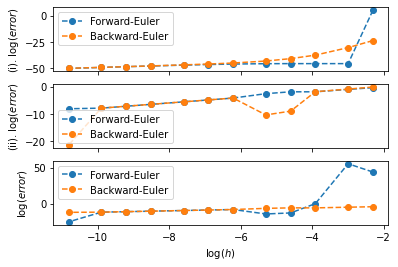

In [2]:
lab = lab3()


def f_lambda_i(u, t):
    return -23 * u


def nabla_f_lambda_i(u, t):
    return -23


def f_lambda_ii(u, t):
    return u


def nabla_f_lambda_ii(u, t):
    return 1


A = np.diag([-1, -100])


def f_lambda_iii(u, t):
    return A @ u


def nabla_f_lambda_iii(u, t):
    return A


h_vals = np.array([.1, .05, .02])
h_vals_exp = 10**(-np.arange(0, 4.))
h_vals_exp = h_vals_exp.reshape(-1, 1)
h_vals = h_vals * h_vals_exp
h_vals = h_vals.reshape(-1)

# (i).
FE_error = []
BE_error = []
FE_N = []
BE_N = []

for h in h_vals:
    u_FE_temp, _, FE_N_temp = lab.Euler(direction="forward",
                                        h=h,
                                        num_iter=np.int(2 / h),
                                        f=f_lambda_i,
                                        u_0=np.array([1.]),
                                        t_0=0.)
    FE_error += [u_FE_temp[-1, 0]]
    FE_N += [FE_N_temp]
    u_BE_temp, _, BE_N_temp = lab.Euler(direction="backward",
                                        h=h,
                                        num_iter=np.int(2 / h),
                                        f=f_lambda_i,
                                        u_0=np.array([1.]),
                                        t_0=0.,
                                        nabla_f=nabla_f_lambda_i)
    BE_error += [u_BE_temp[-1, 0]]
    BE_N += [BE_N_temp]

FE_error = np.array(FE_error) - np.exp(-46)
BE_error = np.array(BE_error) - np.exp(-46)
FE_error_i = np.log(np.abs(FE_error))
BE_error_i = np.log(np.abs(BE_error))
FE_N_i = np.array(FE_N)
BE_N_i = np.array(BE_N)

# (ii).
FE_error = []
BE_error = []
FE_N = []
BE_N = []

for h in h_vals:
    u_FE_temp, _, FE_N_temp = lab.Euler(direction="forward",
                                        h=h,
                                        num_iter=np.int(2 / h),
                                        f=f_lambda_ii,
                                        u_0=np.array([1.]),
                                        t_0=0.)
    FE_error += [u_FE_temp[-1, 0]]
    FE_N += [FE_N_temp]
    u_BE_temp, _, BE_N_temp = lab.Euler(direction="backward",
                                        h=h,
                                        num_iter=np.int(2 / h),
                                        f=f_lambda_ii,
                                        u_0=np.array([1.]),
                                        t_0=0.,
                                        nabla_f=nabla_f_lambda_ii)
    BE_error += [u_BE_temp[-1, 0]]
    BE_N += [BE_N_temp]

FE_error = np.array(FE_error) - np.exp(2)
BE_error = np.array(BE_error) - np.exp(2)
FE_error_ii = np.log(np.abs(FE_error))
BE_error_ii = np.log(np.abs(BE_error))
FE_N_ii = np.array(FE_N)
BE_N_ii = np.array(BE_N)

# (iii).
FE_error = []
BE_error = []
FE_N = []
BE_N = []

for h in h_vals:
    u_FE_temp, _, FE_N_temp = lab.Euler(direction="forward",
                                        h=h,
                                        num_iter=np.int(2 / h),
                                        f=f_lambda_iii,
                                        u_0=np.ones(2),
                                        t_0=0.)
    FE_error += [
        np.linalg.norm(u_FE_temp[-1, :] -
                       np.array([np.exp(-2), np.exp(-200)]))
    ]
    FE_N += [FE_N_temp]
    u_BE_temp, _, BE_N_temp = lab.Euler(direction="backward",
                                        h=h,
                                        num_iter=np.int(2 / h),
                                        f=f_lambda_iii,
                                        u_0=np.ones(2),
                                        t_0=0.,
                                        nabla_f=nabla_f_lambda_iii)
    BE_error += [
        np.linalg.norm(u_BE_temp[-1, :] -
                       np.array([np.exp(-2), np.exp(-200)]))
    ]
    BE_N += [BE_N_temp]

FE_error_iii = np.log(np.abs(FE_error))
BE_error_iii = np.log(np.abs(BE_error))
FE_N_iii = np.array(FE_N)
BE_N_iii = np.array(BE_N)

# plot
fig, axs = plt.subplots(3, 1)
axs[0].plot(np.log(h_vals), FE_error_i, '--o', label="Forward-Euler")
axs[0].plot(np.log(h_vals), BE_error_i, '--o', label="Backward-Euler")
axs[0].set(ylabel=r"(i). $\log(error)$")
axs[0].legend()  # add a legend

axs[1].plot(np.log(h_vals), FE_error_ii, '--o', label="Forward-Euler")
axs[1].plot(np.log(h_vals), BE_error_ii, '--o', label="Backward-Euler")
axs[1].set(ylabel=r"(ii). $\log(error)$")
axs[1].legend()  # add a legend

axs[2].plot(np.log(h_vals), FE_error_iii, '--o', label="Forward-Euler")
axs[2].plot(np.log(h_vals), BE_error_iii, '--o', label="Backward-Euler")
axs[2].set(ylabel=r"(iii). $\log(error)$")
axs[2].legend()  # add a legend
axs[2].set(xlabel=r"$\log(h)$", ylabel=r"$\log(error)$")

for ax in axs.flat:
    ax.label_outer()

plt.show()

### (b). 

**It seems that when comparing $N$, the efficiency for both methods are very close. Especially when $N$ is large, which corresponds to when $h$ is small -- this can be considered as when the interpolation is dense enough, forward and backward doesn't make much of a difference.**

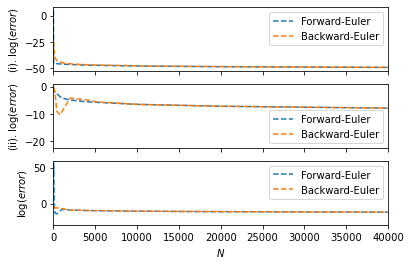

In [3]:
# plot
fig, axs = plt.subplots(3, 1)
axs[0].plot(FE_N_i, FE_error_i, '--', label="Forward-Euler")
axs[0].plot(BE_N_i, BE_error_i, '--', label="Backward-Euler")
axs[0].set(ylabel=r"(i). $\log(error)$", xlim=(0, 4e4))
axs[0].legend()  # add a legend

axs[1].plot(FE_N_ii, FE_error_ii, '--', label="Forward-Euler")
axs[1].plot(BE_N_ii, BE_error_ii, '--', label="Backward-Euler")
axs[1].set(ylabel=r"(ii). $\log(error)$", xlim=(0, 4e4))
axs[1].legend()  # add a legend

axs[2].plot(FE_N_iii, FE_error_iii, '--', label="Forward-Euler")
axs[2].plot(BE_N_iii, BE_error_iii, '--', label="Backward-Euler")
axs[2].set(ylabel=r"(iii). $\log(error)$", xlim=(0, 4e4))
axs[2].legend()  # add a legend
axs[2].set(xlabel=r"$N$", ylabel=r"$\log(error)$")

for ax in axs.flat:
    ax.label_outer()

plt.show()

### (c). 

**Here we choose $h=0.1$ and $h=0.02$ over the interval of $\left[0,20\right]$. Changing of $h$ does change the relative differences between methods, as seen in (i) for both plots below. In general, backward Euler is more likely to "converge" as it incorporates current Euler iteration.**

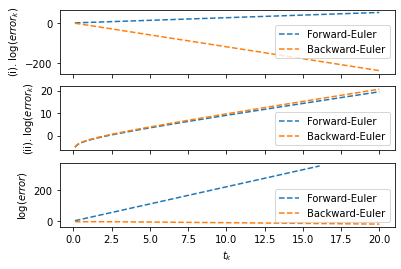

In [4]:
h = .1
u_FE_i, t_FE_i, _ = lab.Euler(direction="forward",
                              h=h,
                              num_iter=np.int(20 / h),
                              f=f_lambda_i,
                              u_0=np.array([1.]),
                              t_0=0.)
u_BE_i, t_BE_i, _ = lab.Euler(direction="backward",
                              h=h,
                              num_iter=np.int(20 / h),
                              f=f_lambda_i,
                              u_0=np.array([1.]),
                              t_0=0.,
                              nabla_f=nabla_f_lambda_i)

y_i = np.exp(-23 * t_FE_i).reshape(-1, 1)
FE_error_i = np.abs(u_FE_i - y_i)
BE_error_i = np.abs(u_BE_i - y_i)
FE_error_i = np.log(FE_error_i.reshape(-1))
BE_error_i = np.log(BE_error_i.reshape(-1))

u_FE_ii, t_FE_ii, _ = lab.Euler(direction="forward",
                                h=h,
                                num_iter=np.int(20 / h),
                                f=f_lambda_ii,
                                u_0=np.array([1.]),
                                t_0=0.)
u_BE_ii, t_BE_ii, _ = lab.Euler(direction="backward",
                                h=h,
                                num_iter=np.int(20 / h),
                                f=f_lambda_ii,
                                u_0=np.array([1.]),
                                t_0=0.,
                                nabla_f=nabla_f_lambda_ii)

y_ii = np.exp(t_FE_ii).reshape(-1, 1)
FE_error_ii = np.abs(u_FE_ii - y_ii)
BE_error_ii = np.abs(u_BE_ii - y_ii)
FE_error_ii = np.log(FE_error_ii.reshape(-1))
BE_error_ii = np.log(BE_error_ii.reshape(-1))

u_FE_iii, t_FE_iii, _ = lab.Euler(direction="forward",
                                  h=h,
                                  num_iter=np.int(20 / h),
                                  f=f_lambda_iii,
                                  u_0=np.ones(2),
                                  t_0=0.)
u_BE_iii, t_BE_iii, _ = lab.Euler(direction="backward",
                                  h=h,
                                  num_iter=np.int(20 / h),
                                  f=f_lambda_iii,
                                  u_0=np.ones(2),
                                  t_0=0.,
                                  nabla_f=nabla_f_lambda_iii)

y_iii = np.exp(np.outer(t_FE_iii, np.array([-1, -100])))
FE_error_iii = np.abs(u_FE_iii - y_iii)
BE_error_iii = np.abs(u_BE_iii - y_iii)
FE_error_iii = np.linalg.norm(FE_error_iii, axis=1)
BE_error_iii = np.linalg.norm(BE_error_iii, axis=1)
FE_error_iii = np.log(FE_error_iii.reshape(-1))
BE_error_iii = np.log(BE_error_iii.reshape(-1))

# plot
fig, axs = plt.subplots(3, 1)
axs[0].plot(t_FE_i, FE_error_i, '--', label="Forward-Euler")
axs[0].plot(t_FE_i, BE_error_i, '--', label="Backward-Euler")
axs[0].set(ylabel=r"(i). $\log(error_k)$")
axs[0].legend()  # add a legend

axs[1].plot(t_FE_ii, FE_error_ii, '--', label="Forward-Euler")
axs[1].plot(t_FE_ii, BE_error_ii, '--', label="Backward-Euler")
axs[1].set(ylabel=r"(ii). $\log(error_k)$")
axs[1].legend()  # add a legend

axs[2].plot(t_FE_iii, FE_error_iii, '--', label="Forward-Euler")
axs[2].plot(t_FE_iii, BE_error_iii, '--', label="Backward-Euler")
axs[2].set(ylabel=r"(iii). $\log(error_k)$")
axs[2].legend()  # add a legend
axs[2].set(xlabel=r"$t_k$", ylabel=r"$\log(error)$")

for ax in axs.flat:
    ax.label_outer()

plt.show()

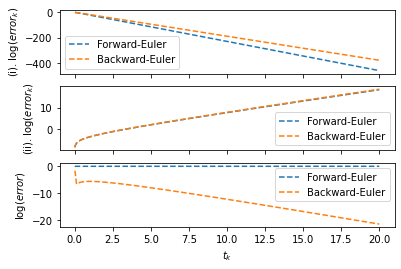

In [5]:
h = .02
u_FE_i, t_FE_i, _ = lab.Euler(direction="forward",
                              h=h,
                              num_iter=np.int(20 / h),
                              f=f_lambda_i,
                              u_0=np.array([1.]),
                              t_0=0.)
u_BE_i, t_BE_i, _ = lab.Euler(direction="backward",
                              h=h,
                              num_iter=np.int(20 / h),
                              f=f_lambda_i,
                              u_0=np.array([1.]),
                              t_0=0.,
                              nabla_f=nabla_f_lambda_i)

y_i = np.exp(-23 * t_FE_i).reshape(-1, 1)
FE_error_i = np.abs(u_FE_i - y_i)
BE_error_i = np.abs(u_BE_i - y_i)
FE_error_i = np.log(FE_error_i.reshape(-1))
BE_error_i = np.log(BE_error_i.reshape(-1))

u_FE_ii, t_FE_ii, _ = lab.Euler(direction="forward",
                                h=h,
                                num_iter=np.int(20 / h),
                                f=f_lambda_ii,
                                u_0=np.array([1.]),
                                t_0=0.)
u_BE_ii, t_BE_ii, _ = lab.Euler(direction="backward",
                                h=h,
                                num_iter=np.int(20 / h),
                                f=f_lambda_ii,
                                u_0=np.array([1.]),
                                t_0=0.,
                                nabla_f=nabla_f_lambda_ii)

y_ii = np.exp(t_FE_ii).reshape(-1, 1)
FE_error_ii = np.abs(u_FE_ii - y_ii)
BE_error_ii = np.abs(u_BE_ii - y_ii)
FE_error_ii = np.log(FE_error_ii.reshape(-1))
BE_error_ii = np.log(BE_error_ii.reshape(-1))

u_FE_iii, t_FE_iii, _ = lab.Euler(direction="forward",
                                  h=h,
                                  num_iter=np.int(20 / h),
                                  f=f_lambda_iii,
                                  u_0=np.ones(2),
                                  t_0=0.)
u_BE_iii, t_BE_iii, _ = lab.Euler(direction="backward",
                                  h=h,
                                  num_iter=np.int(20 / h),
                                  f=f_lambda_iii,
                                  u_0=np.ones(2),
                                  t_0=0.,
                                  nabla_f=nabla_f_lambda_iii)

y_iii = np.exp(np.outer(t_FE_iii, np.array([-1, -100])))
FE_error_iii = np.abs(u_FE_iii - y_iii)
BE_error_iii = np.abs(u_BE_iii - y_iii)
FE_error_iii = np.linalg.norm(FE_error_iii, axis=1)
BE_error_iii = np.linalg.norm(BE_error_iii, axis=1)
FE_error_iii = np.log(FE_error_iii.reshape(-1))
BE_error_iii = np.log(BE_error_iii.reshape(-1))

# plot
fig, axs = plt.subplots(3, 1)
axs[0].plot(t_FE_i, FE_error_i, '--', label="Forward-Euler")
axs[0].plot(t_FE_i, BE_error_i, '--', label="Backward-Euler")
axs[0].set(ylabel=r"(i). $\log(error_k)$")
axs[0].legend()  # add a legend

axs[1].plot(t_FE_ii, FE_error_ii, '--', label="Forward-Euler")
axs[1].plot(t_FE_ii, BE_error_ii, '--', label="Backward-Euler")
axs[1].set(ylabel=r"(ii). $\log(error_k)$")
axs[1].legend()  # add a legend

axs[2].plot(t_FE_iii, FE_error_iii, '--', label="Forward-Euler")
axs[2].plot(t_FE_iii, BE_error_iii, '--', label="Backward-Euler")
axs[2].set(ylabel=r"(iii). $\log(error_k)$")
axs[2].legend()  # add a legend
axs[2].set(xlabel=r"$t_k$", ylabel=r"$\log(error)$")

for ax in axs.flat:
    ax.label_outer()

plt.show()

## Problem 3 
*Using the forward Euler code as a template, implement Runge's second order method $$\begin{array}{c|cc}
0\\
\frac{1}{2} & \frac{1}{2}\\
\hline  & 0 & 1
\end{array}$$ and the four stage method (sometimes called "The Runge-Kutta method"): $$\begin{array}{c|cccc}
0\\
\frac{1}{2} & \frac{1}{2}\\
\frac{1}{2} & 0 & \frac{1}{2}\\
1 & 0 & 0 & 1\\
\hline  & \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}
\end{array}$$ Compare the performance of these methods with the forward and backward Euler methods on the three differential equations considered in the previous exercise (use the same comparisons as in (a), (b) and (c) from that exercise).*

**The implemented functions are `lab3.Runge` for Runge's second order method; and `lab3.RK` for the Runge-Kutta method.**

### (a) 

**As expected, Runge and Runge-Kutta are also explicit methods, which will suffer more from large $h$ -- same as forward Euler's method. As $h$ becomes smaller, the performance of them gets better.**

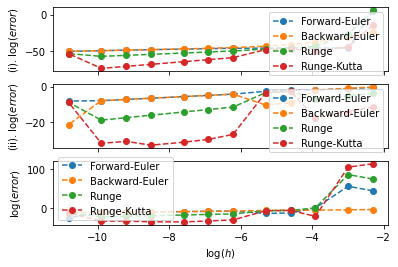

In [6]:
h_vals = np.array([.1, .05, .02])
h_vals_exp = 10**(-np.arange(0, 4.))
h_vals_exp = h_vals_exp.reshape(-1, 1)
h_vals = h_vals * h_vals_exp
h_vals = h_vals.reshape(-1)

# (i).
FE_error = []
BE_error = []
Runge_error = []
RK_error = []
FE_N = []
BE_N = []
Runge_N = []
RK_N = []

for h in h_vals:
    u_FE_temp, _, FE_N_temp = lab.Euler(direction="forward",
                                        h=h,
                                        num_iter=np.int(2 / h),
                                        f=f_lambda_i,
                                        u_0=np.array([1.]),
                                        t_0=0.)
    FE_error += [u_FE_temp[-1, 0]]
    FE_N += [FE_N_temp]
    u_BE_temp, _, BE_N_temp = lab.Euler(direction="backward",
                                        h=h,
                                        num_iter=np.int(2 / h),
                                        f=f_lambda_i,
                                        u_0=np.array([1.]),
                                        t_0=0.,
                                        nabla_f=nabla_f_lambda_i)
    BE_error += [u_BE_temp[-1, 0]]
    BE_N += [BE_N_temp]
    u_Runge_temp, _, Runge_N_temp = lab.Runge(h=h,
                                              num_iter=np.int(2 / h),
                                              f=f_lambda_i,
                                              u_0=np.array([1.]),
                                              t_0=0.)
    Runge_error += [u_Runge_temp[-1, 0]]
    Runge_N += [Runge_N_temp]
    u_RK_temp, _, RK_N_temp = lab.RK(h=h,
                                     num_iter=np.int(2 / h),
                                     f=f_lambda_i,
                                     u_0=np.array([1.]),
                                     t_0=0.)
    RK_error += [u_RK_temp[-1, 0]]
    RK_N += [RK_N_temp]

FE_error = np.array(FE_error) - np.exp(-46)
BE_error = np.array(BE_error) - np.exp(-46)
Runge_error = np.array(Runge_error) - np.exp(-46)
RK_error = np.array(RK_error) - np.exp(-46)
FE_error_i = np.log(np.abs(FE_error))
BE_error_i = np.log(np.abs(BE_error))
Runge_error_i = np.log(np.abs(Runge_error))
RK_error_i = np.log(np.abs(RK_error))
FE_N_i = np.array(FE_N)
BE_N_i = np.array(BE_N)
Runge_N_i = np.array(Runge_N)
RK_N_i = np.array(RK_N)

# (ii).
FE_error = []
BE_error = []
Runge_error = []
RK_error = []
FE_N = []
BE_N = []
Runge_N = []
RK_N = []

for h in h_vals:
    u_FE_temp, _, FE_N_temp = lab.Euler(direction="forward",
                                        h=h,
                                        num_iter=np.int(2 / h),
                                        f=f_lambda_ii,
                                        u_0=np.array([1.]),
                                        t_0=0.)
    FE_error += [u_FE_temp[-1, 0]]
    FE_N += [FE_N_temp]
    u_BE_temp, _, BE_N_temp = lab.Euler(direction="backward",
                                        h=h,
                                        num_iter=np.int(2 / h),
                                        f=f_lambda_ii,
                                        u_0=np.array([1.]),
                                        t_0=0.,
                                        nabla_f=nabla_f_lambda_ii)
    BE_error += [u_BE_temp[-1, 0]]
    BE_N += [BE_N_temp]
    u_Runge_temp, _, Runge_N_temp = lab.Runge(h=h,
                                              num_iter=np.int(2 / h),
                                              f=f_lambda_ii,
                                              u_0=np.array([1.]),
                                              t_0=0.)
    Runge_error += [u_Runge_temp[-1, 0]]
    Runge_N += [Runge_N_temp]
    u_RK_temp, _, RK_N_temp = lab.RK(h=h,
                                     num_iter=np.int(2 / h),
                                     f=f_lambda_ii,
                                     u_0=np.array([1.]),
                                     t_0=0.)
    RK_error += [u_RK_temp[-1, 0]]
    RK_N += [RK_N_temp]

FE_error = np.array(FE_error) - np.exp(2)
BE_error = np.array(BE_error) - np.exp(2)
Runge_error = np.array(Runge_error) - np.exp(2)
RK_error = np.array(RK_error) - np.exp(2)
FE_error_ii = np.log(np.abs(FE_error))
BE_error_ii = np.log(np.abs(BE_error))
Runge_error_ii = np.log(np.abs(Runge_error))
RK_error_ii = np.log(np.abs(RK_error))
FE_N_ii = np.array(FE_N)
BE_N_ii = np.array(BE_N)
Runge_N_ii = np.array(Runge_N)
RK_N_ii = np.array(RK_N)

# (iii).
FE_error = []
BE_error = []
Runge_error = []
RK_error = []
FE_N = []
BE_N = []
Runge_N = []
RK_N = []

for h in h_vals:
    u_FE_temp, _, FE_N_temp = lab.Euler(direction="forward",
                                        h=h,
                                        num_iter=np.int(2 / h),
                                        f=f_lambda_iii,
                                        u_0=np.ones(2),
                                        t_0=0.)
    FE_error += [
        np.linalg.norm(u_FE_temp[-1, :] -
                       np.array([np.exp(-2), np.exp(-200)]))
    ]
    FE_N += [FE_N_temp]
    u_BE_temp, _, BE_N_temp = lab.Euler(direction="backward",
                                        h=h,
                                        num_iter=np.int(2 / h),
                                        f=f_lambda_iii,
                                        u_0=np.ones(2),
                                        t_0=0.,
                                        nabla_f=nabla_f_lambda_iii)
    BE_error += [
        np.linalg.norm(u_BE_temp[-1, :] -
                       np.array([np.exp(-2), np.exp(-200)]))
    ]
    BE_N += [BE_N_temp]
    u_Runge_temp, _, Runge_N_temp = lab.Runge(h=h,
                                              num_iter=np.int(2 / h),
                                              f=f_lambda_iii,
                                              u_0=np.ones(2),
                                              t_0=0.)
    Runge_error += [
        np.linalg.norm(u_Runge_temp[-1, :] -
                       np.array([np.exp(-2), np.exp(-200)]))
    ]
    Runge_N += [Runge_N_temp]
    u_RK_temp, _, RK_N_temp = lab.RK(h=h,
                                     num_iter=np.int(2 / h),
                                     f=f_lambda_iii,
                                     u_0=np.ones(2),
                                     t_0=0.)
    RK_error += [
        np.linalg.norm(u_RK_temp[-1, :] -
                       np.array([np.exp(-2), np.exp(-200)]))
    ]
    RK_N += [RK_N_temp]

FE_error_iii = np.log(np.abs(FE_error))
BE_error_iii = np.log(np.abs(BE_error))
Runge_error_iii = np.log(np.abs(Runge_error))
RK_error_iii = np.log(np.abs(RK_error))
FE_N_iii = np.array(FE_N)
BE_N_iii = np.array(BE_N)
Runge_N_iii = np.array(Runge_N)
RK_N_iii = np.array(RK_N)

# plot
fig, axs = plt.subplots(3, 1)
axs[0].plot(np.log(h_vals), FE_error_i, '--o', label="Forward-Euler")
axs[0].plot(np.log(h_vals), BE_error_i, '--o', label="Backward-Euler")
axs[0].plot(np.log(h_vals), Runge_error_i, '--o', label="Runge")
axs[0].plot(np.log(h_vals), RK_error_i, '--o', label="Runge-Kutta")
axs[0].set(ylabel=r"(i). $\log(error)$")
axs[0].legend()  # add a legend

axs[1].plot(np.log(h_vals), FE_error_ii, '--o', label="Forward-Euler")
axs[1].plot(np.log(h_vals), BE_error_ii, '--o', label="Backward-Euler")
axs[1].plot(np.log(h_vals), Runge_error_ii, '--o', label="Runge")
axs[1].plot(np.log(h_vals), RK_error_ii, '--o', label="Runge-Kutta")
axs[1].set(ylabel=r"(ii). $\log(error)$")
axs[1].legend()  # add a legend

axs[2].plot(np.log(h_vals), FE_error_iii, '--o', label="Forward-Euler")
axs[2].plot(np.log(h_vals), BE_error_iii, '--o', label="Backward-Euler")
axs[2].plot(np.log(h_vals), Runge_error_iii, '--o', label="Runge")
axs[2].plot(np.log(h_vals), RK_error_iii, '--o', label="Runge-Kutta")
axs[2].set(ylabel=r"(iii). $\log(error)$")
axs[2].legend()  # add a legend
axs[2].set(xlabel=r"$\log(h)$", ylabel=r"$\log(error)$")

for ax in axs.flat:
    ax.label_outer()

plt.show()

### (b). 

**Overall in terms of efficiency, Runge-Kutta performs the best, while Runge performs second-best.**

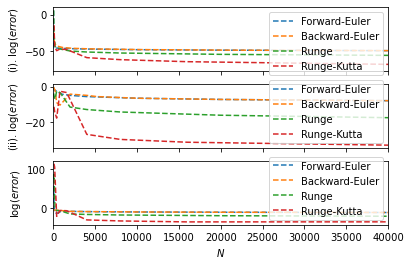

In [7]:
# plot
fig, axs = plt.subplots(3, 1)
axs[0].plot(FE_N_i, FE_error_i, '--', label="Forward-Euler")
axs[0].plot(BE_N_i, BE_error_i, '--', label="Backward-Euler")
axs[0].plot(Runge_N_i, Runge_error_i, '--', label="Runge")
axs[0].plot(RK_N_i, RK_error_i, '--', label="Runge-Kutta")
axs[0].set(ylabel=r"(i). $\log(error)$", xlim=(0, 4e4))
axs[0].legend()  # add a legend

axs[1].plot(FE_N_ii, FE_error_ii, '--', label="Forward-Euler")
axs[1].plot(BE_N_ii, BE_error_ii, '--', label="Backward-Euler")
axs[1].plot(Runge_N_ii, Runge_error_ii, '--', label="Runge")
axs[1].plot(RK_N_ii, RK_error_ii, '--', label="Runge-Kutta")
axs[1].set(ylabel=r"(ii). $\log(error)$", xlim=(0, 4e4))
axs[1].legend()  # add a legend

axs[2].plot(FE_N_iii, FE_error_iii, '--', label="Forward-Euler")
axs[2].plot(BE_N_iii, BE_error_iii, '--', label="Backward-Euler")
axs[2].plot(Runge_N_iii, Runge_error_iii, '--', label="Runge")
axs[2].plot(RK_N_iii, RK_error_iii, '--', label="Runge-Kutta")
axs[2].set(ylabel=r"(iii). $\log(error)$", xlim=(0, 4e4))
axs[2].legend()  # add a legend
axs[2].set(xlabel=r"$N$", ylabel=r"$\log(error)$")

for ax in axs.flat:
    ax.label_outer()

plt.show()

### (c).

**Same as discussed before, as explicit methods, Runge and Runge-Kutta still more likely suffer from "non-converging" than backward Euler -- though our simulation shows they are more robust than forward Euler. In fact besides in (ii) when there's not much curvature information, backward Euler usually "converges." The value of $h$ still influences the relative differences between methods.**

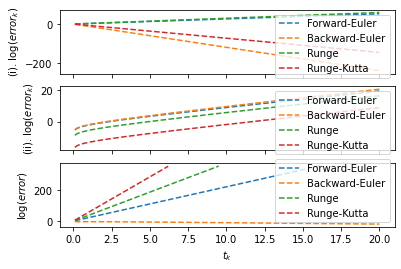

In [8]:
h = .1
u_FE_i, t_FE_i, _ = lab.Euler(direction="forward",
                              h=h,
                              num_iter=np.int(20 / h),
                              f=f_lambda_i,
                              u_0=np.array([1.]),
                              t_0=0.)
u_BE_i, t_BE_i, _ = lab.Euler(direction="backward",
                              h=h,
                              num_iter=np.int(20 / h),
                              f=f_lambda_i,
                              u_0=np.array([1.]),
                              t_0=0.,
                              nabla_f=nabla_f_lambda_i)
u_Runge_i, t_Runge_i, _ = lab.Runge(h=h,
                                    num_iter=np.int(20 / h),
                                    f=f_lambda_i,
                                    u_0=np.array([1.]),
                                    t_0=0.)
u_RK_i, t_RK_i, _ = lab.RK(h=h,
                           num_iter=np.int(20 / h),
                           f=f_lambda_i,
                           u_0=np.array([1.]),
                           t_0=0.)

y_i = np.exp(-23 * t_FE_i).reshape(-1, 1)
FE_error_i = np.abs(u_FE_i - y_i)
BE_error_i = np.abs(u_BE_i - y_i)
Runge_error_i = np.abs(u_Runge_i - y_i)
RK_error_i = np.abs(u_RK_i - y_i)
FE_error_i = np.log(FE_error_i.reshape(-1))
BE_error_i = np.log(BE_error_i.reshape(-1))
Runge_error_i = np.log(Runge_error_i.reshape(-1))
RK_error_i = np.log(RK_error_i.reshape(-1))

u_FE_ii, t_FE_ii, _ = lab.Euler(direction="forward",
                                h=h,
                                num_iter=np.int(20 / h),
                                f=f_lambda_ii,
                                u_0=np.array([1.]),
                                t_0=0.)
u_BE_ii, t_BE_ii, _ = lab.Euler(direction="backward",
                                h=h,
                                num_iter=np.int(20 / h),
                                f=f_lambda_ii,
                                u_0=np.array([1.]),
                                t_0=0.,
                                nabla_f=nabla_f_lambda_ii)
u_Runge_ii, t_Runge_ii, _ = lab.Runge(h=h,
                                      num_iter=np.int(20 / h),
                                      f=f_lambda_ii,
                                      u_0=np.array([1.]),
                                      t_0=0.)
u_RK_ii, t_RK_ii, _ = lab.RK(h=h,
                             num_iter=np.int(20 / h),
                             f=f_lambda_ii,
                             u_0=np.array([1.]),
                             t_0=0.)

y_ii = np.exp(t_FE_ii).reshape(-1, 1)
FE_error_ii = np.abs(u_FE_ii - y_ii)
BE_error_ii = np.abs(u_BE_ii - y_ii)
Runge_error_ii = np.abs(u_Runge_ii - y_ii)
RK_error_ii = np.abs(u_RK_ii - y_ii)
FE_error_ii = np.log(FE_error_ii.reshape(-1))
BE_error_ii = np.log(BE_error_ii.reshape(-1))
Runge_error_ii = np.log(Runge_error_ii.reshape(-1))
RK_error_ii = np.log(RK_error_ii.reshape(-1))

u_FE_iii, t_FE_iii, _ = lab.Euler(direction="forward",
                                  h=h,
                                  num_iter=np.int(20 / h),
                                  f=f_lambda_iii,
                                  u_0=np.ones(2),
                                  t_0=0.)
u_BE_iii, t_BE_iii, _ = lab.Euler(direction="backward",
                                  h=h,
                                  num_iter=np.int(20 / h),
                                  f=f_lambda_iii,
                                  u_0=np.ones(2),
                                  t_0=0.,
                                  nabla_f=nabla_f_lambda_iii)
u_Runge_iii, t_Runge_iii, _ = lab.Runge(h=h,
                                        num_iter=np.int(20 / h),
                                        f=f_lambda_iii,
                                        u_0=np.ones(2),
                                        t_0=0.)
u_RK_iii, t_RK_iii, _ = lab.RK(h=h,
                               num_iter=np.int(20 / h),
                               f=f_lambda_iii,
                               u_0=np.ones(2),
                               t_0=0.)

y_iii = np.exp(np.outer(t_FE_iii, np.array([-1, -100])))
FE_error_iii = np.abs(u_FE_iii - y_iii)
BE_error_iii = np.abs(u_BE_iii - y_iii)
Runge_error_iii = np.abs(u_Runge_iii - y_iii)
RK_error_iii = np.abs(u_RK_iii - y_iii)
FE_error_iii = np.linalg.norm(FE_error_iii, axis=1)
BE_error_iii = np.linalg.norm(BE_error_iii, axis=1)
Runge_error_iii = np.linalg.norm(Runge_error_iii, axis=1)
RK_error_iii = np.linalg.norm(RK_error_iii, axis=1)
FE_error_iii = np.log(FE_error_iii.reshape(-1))
BE_error_iii = np.log(BE_error_iii.reshape(-1))
Runge_error_iii = np.log(Runge_error_iii.reshape(-1))
RK_error_iii = np.log(RK_error_iii.reshape(-1))

# plot
fig, axs = plt.subplots(3, 1)
axs[0].plot(t_FE_i, FE_error_i, '--', label="Forward-Euler")
axs[0].plot(t_FE_i, BE_error_i, '--', label="Backward-Euler")
axs[0].plot(t_FE_i, Runge_error_i, '--', label="Runge")
axs[0].plot(t_FE_i, RK_error_i, '--', label="Runge-Kutta")
axs[0].set(ylabel=r"(i). $\log(error_k)$")
axs[0].legend()  # add a legend

axs[1].plot(t_FE_ii, FE_error_ii, '--', label="Forward-Euler")
axs[1].plot(t_FE_ii, BE_error_ii, '--', label="Backward-Euler")
axs[1].plot(t_FE_ii, Runge_error_ii, '--', label="Runge")
axs[1].plot(t_FE_ii, RK_error_ii, '--', label="Runge-Kutta")
axs[1].set(ylabel=r"(ii). $\log(error_k)$")
axs[1].legend()  # add a legend

axs[2].plot(t_FE_iii, FE_error_iii, '--', label="Forward-Euler")
axs[2].plot(t_FE_iii, BE_error_iii, '--', label="Backward-Euler")
axs[2].plot(t_FE_iii, Runge_error_iii, '--', label="Runge")
axs[2].plot(t_FE_iii, RK_error_iii, '--', label="Runge-Kutta")
axs[2].set(ylabel=r"(iii). $\log(error_k)$")
axs[2].legend()  # add a legend
axs[2].set(xlabel=r"$t_k$", ylabel=r"$\log(error)$")

for ax in axs.flat:
    ax.label_outer()

plt.show()

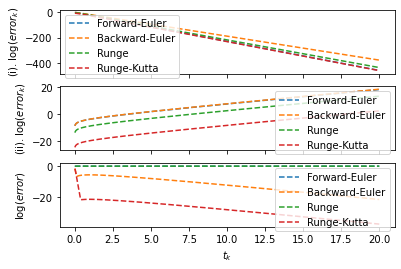

In [9]:
h = .02
u_FE_i, t_FE_i, _ = lab.Euler(direction="forward",
                              h=h,
                              num_iter=np.int(20 / h),
                              f=f_lambda_i,
                              u_0=np.array([1.]),
                              t_0=0.)
u_BE_i, t_BE_i, _ = lab.Euler(direction="backward",
                              h=h,
                              num_iter=np.int(20 / h),
                              f=f_lambda_i,
                              u_0=np.array([1.]),
                              t_0=0.,
                              nabla_f=nabla_f_lambda_i)
u_Runge_i, t_Runge_i, _ = lab.Runge(h=h,
                                    num_iter=np.int(20 / h),
                                    f=f_lambda_i,
                                    u_0=np.array([1.]),
                                    t_0=0.)
u_RK_i, t_RK_i, _ = lab.RK(h=h,
                           num_iter=np.int(20 / h),
                           f=f_lambda_i,
                           u_0=np.array([1.]),
                           t_0=0.)

y_i = np.exp(-23 * t_FE_i).reshape(-1, 1)
FE_error_i = np.abs(u_FE_i - y_i)
BE_error_i = np.abs(u_BE_i - y_i)
Runge_error_i = np.abs(u_Runge_i - y_i)
RK_error_i = np.abs(u_RK_i - y_i)
FE_error_i = np.log(FE_error_i.reshape(-1))
BE_error_i = np.log(BE_error_i.reshape(-1))
Runge_error_i = np.log(Runge_error_i.reshape(-1))
RK_error_i = np.log(RK_error_i.reshape(-1))

u_FE_ii, t_FE_ii, _ = lab.Euler(direction="forward",
                                h=h,
                                num_iter=np.int(20 / h),
                                f=f_lambda_ii,
                                u_0=np.array([1.]),
                                t_0=0.)
u_BE_ii, t_BE_ii, _ = lab.Euler(direction="backward",
                                h=h,
                                num_iter=np.int(20 / h),
                                f=f_lambda_ii,
                                u_0=np.array([1.]),
                                t_0=0.,
                                nabla_f=nabla_f_lambda_ii)
u_Runge_ii, t_Runge_ii, _ = lab.Runge(h=h,
                                      num_iter=np.int(20 / h),
                                      f=f_lambda_ii,
                                      u_0=np.array([1.]),
                                      t_0=0.)
u_RK_ii, t_RK_ii, _ = lab.RK(h=h,
                             num_iter=np.int(20 / h),
                             f=f_lambda_ii,
                             u_0=np.array([1.]),
                             t_0=0.)

y_ii = np.exp(t_FE_ii).reshape(-1, 1)
FE_error_ii = np.abs(u_FE_ii - y_ii)
BE_error_ii = np.abs(u_BE_ii - y_ii)
Runge_error_ii = np.abs(u_Runge_ii - y_ii)
RK_error_ii = np.abs(u_RK_ii - y_ii)
FE_error_ii = np.log(FE_error_ii.reshape(-1))
BE_error_ii = np.log(BE_error_ii.reshape(-1))
Runge_error_ii = np.log(Runge_error_ii.reshape(-1))
RK_error_ii = np.log(RK_error_ii.reshape(-1))

u_FE_iii, t_FE_iii, _ = lab.Euler(direction="forward",
                                  h=h,
                                  num_iter=np.int(20 / h),
                                  f=f_lambda_iii,
                                  u_0=np.ones(2),
                                  t_0=0.)
u_BE_iii, t_BE_iii, _ = lab.Euler(direction="backward",
                                  h=h,
                                  num_iter=np.int(20 / h),
                                  f=f_lambda_iii,
                                  u_0=np.ones(2),
                                  t_0=0.,
                                  nabla_f=nabla_f_lambda_iii)
u_Runge_iii, t_Runge_iii, _ = lab.Runge(h=h,
                                        num_iter=np.int(20 / h),
                                        f=f_lambda_iii,
                                        u_0=np.ones(2),
                                        t_0=0.)
u_RK_iii, t_RK_iii, _ = lab.RK(h=h,
                               num_iter=np.int(20 / h),
                               f=f_lambda_iii,
                               u_0=np.ones(2),
                               t_0=0.)

y_iii = np.exp(np.outer(t_FE_iii, np.array([-1, -100])))
FE_error_iii = np.abs(u_FE_iii - y_iii)
BE_error_iii = np.abs(u_BE_iii - y_iii)
Runge_error_iii = np.abs(u_Runge_iii - y_iii)
RK_error_iii = np.abs(u_RK_iii - y_iii)
FE_error_iii = np.linalg.norm(FE_error_iii, axis=1)
BE_error_iii = np.linalg.norm(BE_error_iii, axis=1)
Runge_error_iii = np.linalg.norm(Runge_error_iii, axis=1)
RK_error_iii = np.linalg.norm(RK_error_iii, axis=1)
FE_error_iii = np.log(FE_error_iii.reshape(-1))
BE_error_iii = np.log(BE_error_iii.reshape(-1))
Runge_error_iii = np.log(Runge_error_iii.reshape(-1))
RK_error_iii = np.log(RK_error_iii.reshape(-1))

# plot
fig, axs = plt.subplots(3, 1)
axs[0].plot(t_FE_i, FE_error_i, '--', label="Forward-Euler")
axs[0].plot(t_FE_i, BE_error_i, '--', label="Backward-Euler")
axs[0].plot(t_FE_i, Runge_error_i, '--', label="Runge")
axs[0].plot(t_FE_i, RK_error_i, '--', label="Runge-Kutta")
axs[0].set(ylabel=r"(i). $\log(error_k)$")
axs[0].legend()  # add a legend

axs[1].plot(t_FE_ii, FE_error_ii, '--', label="Forward-Euler")
axs[1].plot(t_FE_ii, BE_error_ii, '--', label="Backward-Euler")
axs[1].plot(t_FE_ii, Runge_error_ii, '--', label="Runge")
axs[1].plot(t_FE_ii, RK_error_ii, '--', label="Runge-Kutta")
axs[1].set(ylabel=r"(ii). $\log(error_k)$")
axs[1].legend()  # add a legend

axs[2].plot(t_FE_iii, FE_error_iii, '--', label="Forward-Euler")
axs[2].plot(t_FE_iii, BE_error_iii, '--', label="Backward-Euler")
axs[2].plot(t_FE_iii, Runge_error_iii, '--', label="Runge")
axs[2].plot(t_FE_iii, RK_error_iii, '--', label="Runge-Kutta")
axs[2].set(ylabel=r"(iii). $\log(error_k)$")
axs[2].legend()  # add a legend
axs[2].set(xlabel=r"$t_k$", ylabel=r"$\log(error)$")

for ax in axs.flat:
    ax.label_outer()

plt.show()

## Problem 4 
*In this exercise, we will study the motion of the five outer planets relative to the sun using different numerical integrators. The necessary data is given in file `outer.txt`. In the data file the units are chosen so that the sun has mass 1, the distances are in astronomical units (1a.u.$=149,597,870$km), and times in earth days. The sun and the inner planets are to be collectively treated as one object. When you copy and run `outer.txt` in Python, the data will be loaded to three variables `g`, `m`, and `x`; where `g` holds the value of the universal gravitational constant, `m` is an array consisting of the masses of the $6$ objects, and `x` is an array with initial positions and velocities of the objects, corresponding to September 5, 1994 at UTC 0:00. Further comments can be found in the file `outer.txt`.* 



**While this problem is a second-order ODE problem *per se*, its numerical solution can actually be found by writing it in a first-order ODE form instead (i.e., we put both positions *and* velocities as the vector valued function so its first-order gradient will be a function of itself), and implement various numerical methods discussed before.**

**The motion for the next $8000$ years with step size $30$ days are simulated using the Runge-Kutta method -- the method we found to perform relatively well in above problems; and it turns out in the end, the sun's position will change -- despite its much larger mass than other planets. Nothing surprising will happen (like any planet flies away from the solar system, or any planet collapses into the sun -- nothing like this will happen...), the simulated positions and velocities are reported below.**

**As a final remark, recall that in consideration of $N$, implicit methods might not perform very well comparing to many explicit methods. So for this problem, we only use explicit $4$-stage Runge-Kutta here.**

In [10]:
# open the data file for this problem
exec(open('outer.txt').read())
m = np.array(m)
x = np.array(x)
print("The gravitational constant and masses are already here: g =", g,
      ", m =", m)


def f_motion(u, t):
    '''
    Function to calculate first-order derivative for the system we discussed above
    '''
    output = np.empty_like(u)
    output[0:18] = u[18:36]
    _position = u.reshape(-1, 3)[:6, :]
    _position = np.tile(_position, (6, 1)) - np.repeat(_position, 6, axis=0)
    _norm = np.linalg.norm(
        _position, axis=1
    )**3  # here we use cubic of l-2 norm because there should be 2 degree for r^2 and one degree to normalizing the direction vector
    _norm = _norm.reshape(-1, 1)
    _position /= _norm
    _position = _position.reshape(-1, 6, 3) * (m.reshape(1, 6, 1))
    output[18:] = g * np.nansum(_position, axis=1).reshape(-1)
    return output


u, t, _ = lab.RK(h=30, num_iter=12 * 8000, f=f_motion, u_0=x, t_0=0.)

print(
    "After 8000 years, the position for each planet is (each row is the coordinate for one planet): "
)
print(u[-1, :18].reshape(-1, 3))
print(
    "After 8000 years, the velocity for each planet is (each row is the coordinate for one planet): "
)
print(u[-1, 18:].reshape(-1, 3))

The gravitational constant and masses are already here: g = 0.000295912208286 , m = [1.00000598e+00 9.54786104e-04 2.85583733e-04 4.37273165e-05
 5.17759138e-05 7.69230769e-09]
After 8000 years, the position for each planet is (each row is the coordinate for one planet): 
[[ 17.79290744  -7.01828695  -3.52719728]
 [ 13.45946788  -4.24959981  -2.25858365]
 [ 11.46450494 -13.63353388  -6.08905463]
 [  7.70441917 -21.55687576  -9.73034983]
 [  2.32375625 -31.30653083 -13.07618348]
 [ -0.69579972  24.34469625  11.98008705]]
After 8000 years, the velocity for each planet is (each row is the coordinate for one planet): 
[[ 9.10458057e-06  3.86821290e-06  1.39908227e-06]
 [-4.57541700e-03 -5.39760775e-03 -2.16847106e-03]
 [ 4.07549462e-03 -3.45638207e-03 -1.67558182e-03]
 [ 3.31325048e-03 -2.08415298e-03 -9.49347352e-04]
 [ 2.68398906e-03 -1.44338012e-03 -6.58892256e-04]
 [-1.89920168e-03 -1.95878616e-03 -4.08315647e-05]]
